In [1]:
# Leave lines below uncommented this if you get:
# OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Imports
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import gc

In [2]:
from glomerulus import Glomerulus, Patch, KidneySampleDataset, get_glomeruli, generate_glomerulus_patches
from networks import R2UNet
from utils import read_tiff, dataset_label_mean, adjusted_mse

In [3]:
TEST_IMAGE_PATH = './kidney_dataset/train/aaa6a05cc.tiff'
TEST_LABEL_PATH = './kidney_dataset/train/aaa6a05cc.json'

TRAIN_IMAGE_PATH = './kidney_dataset/train/2f6ecfcdf.tiff'
TRAIN_LABEL_PATH = './kidney_dataset/train/2f6ecfcdf.json'

test_image = read_tiff(TEST_IMAGE_PATH)
train_image = read_tiff(TRAIN_IMAGE_PATH)

C:\Users\iraha\anaconda3\lib\site-packages\rasterio\__init__.py:320: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


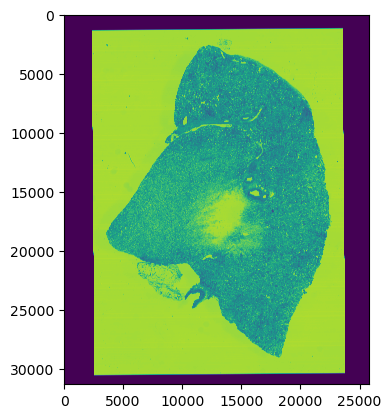

In [4]:
plt.imshow(np.transpose(train_image, (1, 2, 0)))

In [140]:
patch_size = 512
model_resolution = 128
num_train_samples = 1000
num_val_samples = 100
batch_size = 100

model_name = 'CBAM_R2UNet'
loss_name = 'Weighted_BCE_Dice'

dtype = torch.cuda.FloatTensor

In [141]:
train_glomeruli = get_glomeruli(TRAIN_LABEL_PATH,'glomerulus')
val_glomeruli = get_glomeruli(TEST_LABEL_PATH,'glomerulus')

# Generate patch samples from image
train_patches = generate_glomerulus_patches(
    patch_size = patch_size,
    num_patches = num_train_samples,
    glomeruli = train_glomeruli,
    image = train_image
)

val_patches = generate_glomerulus_patches(
    patch_size = patch_size,
    num_patches = num_val_samples,
    glomeruli = val_glomeruli,
    image = test_image
)

train_dataset = KidneySampleDataset(train_patches)
val_dataset = KidneySampleDataset(val_patches)

# Calculate dataset mean
label_mean = dataset_label_mean(train_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Dataset Mean:   0%|          | 0/1000 [00:00<?, ?it/s]

In [142]:
label_mean

0.15196815296635033

In [143]:
model = CBAM_R2UNet((model_resolution, model_resolution), (patch_size, patch_size)).cuda()

In [144]:
# model.forward(torch.randn(1, 1, 512, 512).cuda()).size()
# cbam_block = CBAM_R2Block(
#     layer_type = 'Conv2d',
#     in_channels = 128, 
#     out_channels = 128, 
#     hidden_channels = 256 ,
#     num_layers = 2,
#     activation_type = 'ReLU'
# )
# x = torch.randn(1, 128, 128, 128)
# x = cbam_block.conv_in(x)
# r2_out = cbam_block.sequential(x) + x
# out = cbam_block.conv_out(r2_out)
# # out.size()
# out = out * cbam_block.cbam(out)
# # CBAM_R2Block(16)

In [145]:
def dice_loss(predicted, target, smooth=0.00001):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target)
    dice = 1 - (2 * intersection + smooth) / (union + smooth)
    return dice
def bce_weighted_dice_loss(predicted, target, weights, smooth=0.00001):
    # Clamp values to avoid numerical instability
    predicted = torch.clamp(predicted,min=1e-7,max=1-1e-7)
    bce = - weights[1] * target * torch.log(predicted) - (1 - target) * weights[0] * torch.log(1 - predicted)
    bce = torch.mean(bce) + dice_loss(predicted, target, smooth)
    return bce

In [147]:
train_loss = []
val_loss = []

def train(model, label_mean, epochs=100):
    gc.collect()
    torch.cuda.empty_cache()
    
    best_weights = None
    best_loss = 10000000
    
    train_loss = []
    val_loss = []
    

    criterion = bce_weighted_dice_loss
    optimizer = optim.Adam(model.parameters(), lr=0.008, weight_decay=1e-6)
    pbar = tqdm(total=epochs, desc='Training')
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        
        for inputs, labels in train_dataloader:
            gc.collect()
            torch.cuda.empty_cache()
            # Move data to GPU
            inputs = inputs.type(dtype)
            labels = labels.type(dtype)
            # Run model
            outputs = model.forward(inputs)

            loss = criterion(outputs, labels, [1-label_mean, label_mean]).cuda()
            optimizer.zero_grad()
            loss.backward()

            running_loss += loss.item()
            optimizer.step()
            
        train_epoch_loss = running_loss / len(train_dataloader)
        train_loss.append(train_epoch_loss)

        # Val
        model.eval()
        running_loss = 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                gc.collect()
                torch.cuda.empty_cache()
                # Move data to GPU
                inputs = inputs.type(dtype)
                labels = labels.type(dtype)
                # Run model
                outputs = model.forward(inputs)

                loss = criterion(outputs, labels, [1-label_mean, label_mean]).cuda()
                running_loss += loss.item()
        val_epoch_loss = running_loss / len(val_dataloader)
        val_loss.append(val_epoch_loss)
        
        # Save model every epochs
        torch.save(model.state_dict(), f'./models/{model_name}_{loss_name}_t{str(num_train_samples)}_{str(epoch+1)}.npz')
            
        # Keep track of best weights
        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss
            best_weights = model.state_dict()
            
        pbar.set_postfix({'Train Loss': train_epoch_loss, 'Val Loss': val_epoch_loss, 'Best Val': best_loss})
        pbar.update(1)
    # Save weights with best loss
    torch.save(best_weights, f'./models/{model_name}_{loss_name}_t{str(num_train_samples)}_best_loss.npz')
    return model, train_loss, val_loss

# For debugging
torch.autograd.set_detect_anomaly(True)

# Train model
model, train_loss, val_loss = train(model, label_mean, epochs=100)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import json

with open(f'./models/{model_name}_{loss_name}_t{str(num_train_samples)}_train_loss.json', 'w') as f:
    # indent=2 is not needed but makes the file human-readable 
    # if the data is nested
    json.dump(train_loss, f, indent=2) 

with open(f'./models/{model_name}_{loss_name}_t{str(num_train_samples)}_val_loss.json', 'w') as f:
    # indent=2 is not needed but makes the file human-readable 
    # if the data is nested
    json.dump(val_loss, f, indent=2) 

In [60]:
plt.plot(np.arange(100), train_loss, label='Training Loss')
plt.plot(np.arange(100), val_loss, label='Validation Loss')
plt.legend(loc="upper right")
plt.show()

NameError: name 'train_loss' is not defined

In [111]:
for idx in range(10):
    model.load_state_dict(torch.load(f'./models/R2UNet_Adjusted_MSE/R2UNet_{idx+1}0.npz'))

SyntaxError: expected ':' (3884604456.py, line 1)

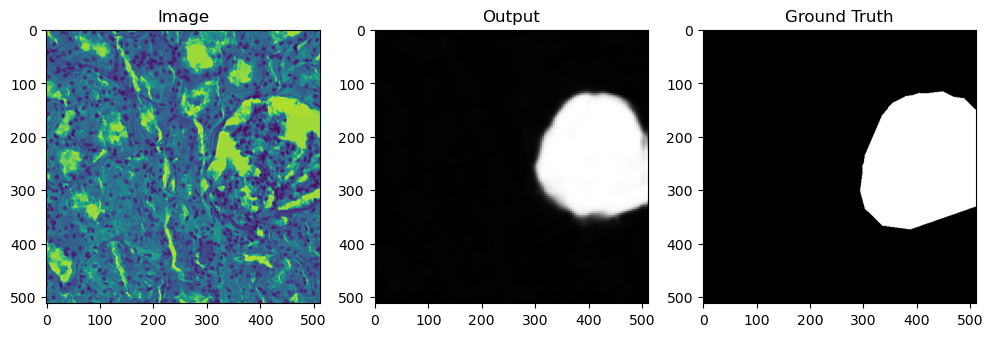

bce_weighted_dice: 0.22772735357284546
bce: 0.09827996790409088
dice: 0.16612929105758667
adjusted_mse: 0.09823069721460342


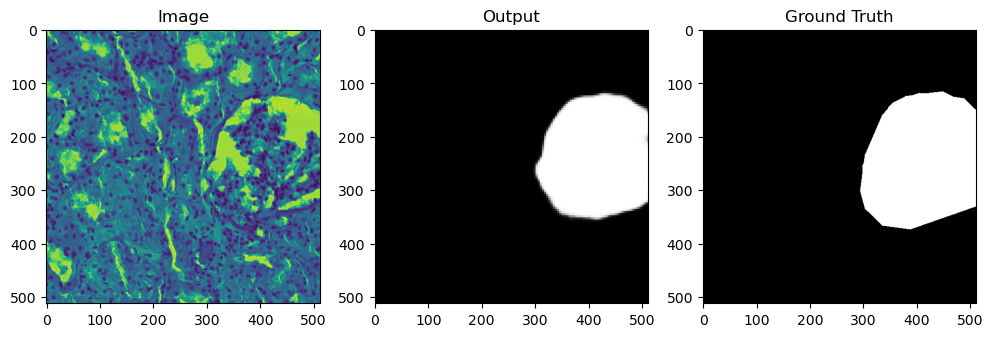

bce_weighted_dice: 0.13767698407173157
bce: 0.07971076667308807
dice: 0.07305431365966797
adjusted_mse: 0.028053482994437218


In [176]:
model = CBAM_R2UNet((model_resolution, model_resolution), (patch_size, patch_size)).cuda()
model.load_state_dict(torch.load(f'./models/CBAM_R2UNet_Weighted_BCE_Dice_t1000_34.npz'))

ID = 15
dataset = val_dataset

out = model.forward(torch.tensor([dataset[ID][0]]).type(dtype))
f, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].imshow(np.transpose(dataset[ID][0], (1, 2, 0)))
axes[1].imshow(np.transpose(out.cpu().detach().numpy()[0], (1, 2, 0)), cmap='gray')
axes[2].imshow(np.transpose(dataset[ID][1], (1, 2, 0)), cmap='gray')
axes[0].set_title('Image')
axes[1].set_title('Output')
axes[2].set_title('Ground Truth')
plt.show()


bce_loss = torch.nn.BCELoss()
print(f'bce_weighted_dice: {bce_weighted_dice_loss(out, torch.tensor([dataset[ID][1]]).type(dtype), [0.15, 0.85]).cuda()}')
print(f'bce: {bce_loss(out, torch.tensor([dataset[ID][1]]).type(dtype)).cuda()}')
print(f'dice: {dice_loss(out, torch.tensor([dataset[ID][1]]).type(dtype)).cuda()}')
print(f'adjusted_mse: {adjusted_mse(out, torch.tensor([dataset[ID][1]]).type(dtype), 0.15).cuda()}')

model = UNet((model_resolution, model_resolution), (patch_size, patch_size)).cuda()
model.load_state_dict(torch.load(f'./models/UNet_Weighted_BCE_Dice_t1000_best_loss.npz'))


out = model.forward(torch.tensor([dataset[ID][0]]).type(dtype))
f, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].imshow(np.transpose(dataset[ID][0], (1, 2, 0)))
axes[1].imshow(np.transpose(out.cpu().detach().numpy()[0], (1, 2, 0)), cmap='gray')
axes[2].imshow(np.transpose(dataset[ID][1], (1, 2, 0)), cmap='gray')
axes[0].set_title('Image')
axes[1].set_title('Output')
axes[2].set_title('Ground Truth')
plt.show()


bce_loss = torch.nn.BCELoss()
print(f'bce_weighted_dice: {bce_weighted_dice_loss(out, torch.tensor([dataset[ID][1]]).type(dtype), [0.15, 0.85]).cuda()}')
print(f'bce: {bce_loss(out, torch.tensor([dataset[ID][1]]).type(dtype)).cuda()}')
print(f'dice: {dice_loss(out, torch.tensor([dataset[ID][1]]).type(dtype)).cuda()}')
print(f'adjusted_mse: {adjusted_mse(out, torch.tensor([dataset[ID][1]]).type(dtype), 0.15).cuda()}')

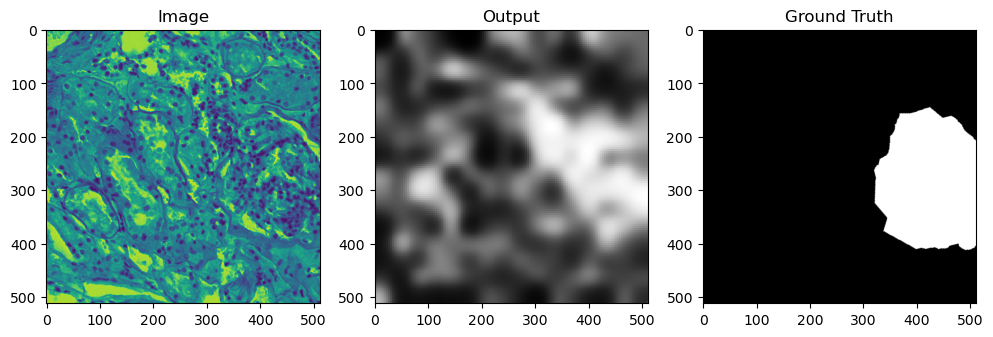

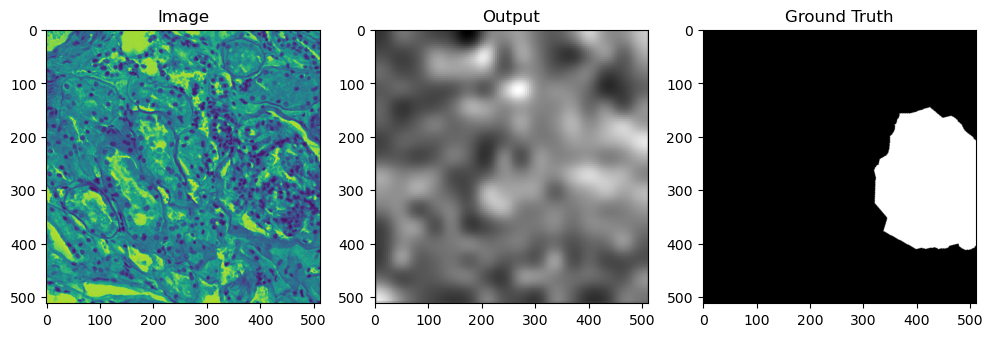

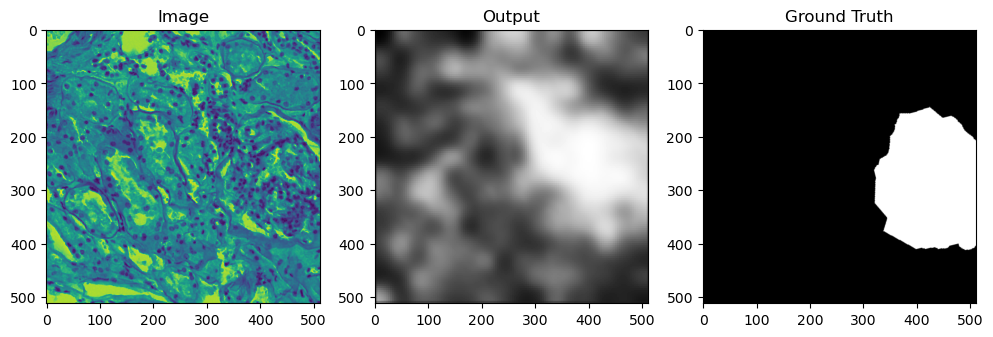

bce_weighted_dice: 0.6022903323173523
dice: 0.6011793613433838
adjusted_mse: 7.387866020202637


In [35]:
ID = 1
dataset = val_dataset

model.load_state_dict(torch.load(f'./models/R2UNet_Adjusted_MSE/R2UNet_10.npz'))

out = model.forward(torch.tensor([dataset[ID][0]]).type(dtype))
f, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].imshow(np.transpose(dataset[ID][0], (1, 2, 0)))
axes[1].imshow(np.transpose(out.cpu().detach().numpy()[0], (1, 2, 0)), cmap='gray')
axes[2].imshow(np.transpose(dataset[ID][1], (1, 2, 0)), cmap='gray')
axes[0].set_title('Image')
axes[1].set_title('Output')
axes[2].set_title('Ground Truth')
plt.show()

model.load_state_dict(torch.load(f'./models/R2UNet_Adjusted_MSE/R2UNet_100.npz'))

out = model.forward(torch.tensor([dataset[ID][0]]).type(dtype))
f, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].imshow(np.transpose(dataset[ID][0], (1, 2, 0)))
axes[1].imshow(np.transpose(out.cpu().detach().numpy()[0], (1, 2, 0)), cmap='gray')
axes[2].imshow(np.transpose(dataset[ID][1], (1, 2, 0)), cmap='gray')
axes[0].set_title('Image')
axes[1].set_title('Output')
axes[2].set_title('Ground Truth')
plt.show()

# # bce_loss = nn.BCELoss()
# print(f'bce_weighted_dice: {bce_weighted_dice_loss(out, torch.tensor([dataset[ID][1]]).type(dtype), [0.15, 0.85]).cuda()}')
# print(f'dice: {dice_loss(out, torch.tensor([dataset[ID][1]]).type(dtype)).cuda()}')
# # print(f'bce: {bce_loss(out, torch.tensor([dataset[ID][1]]).type(dtype)).cuda()}')
# print(f'adjusted_mse: {adjusted_mse(out, torch.tensor([dataset[ID][1]]).type(dtype), 0.15).cuda()}')

model.load_state_dict(torch.load(f'./models/R2UNet_Weighted_BCE_Dice_t100_10.npz'))

out = model.forward(torch.tensor([dataset[ID][0]]).type(dtype))
f, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].imshow(np.transpose(dataset[ID][0], (1, 2, 0)))
axes[1].imshow(np.transpose(out.cpu().detach().numpy()[0], (1, 2, 0)), cmap='gray')
axes[2].imshow(np.transpose(dataset[ID][1], (1, 2, 0)), cmap='gray')
axes[0].set_title('Image')
axes[1].set_title('Output')
axes[2].set_title('Ground Truth')
plt.show()

print(f'bce_weighted_dice: {bce_weighted_dice_loss(out, torch.tensor([dataset[ID][1]]).type(dtype), [0.15, 0.85]).cuda()}')
print(f'dice: {dice_loss(out, torch.tensor([dataset[ID][1]]).type(dtype)).cuda()}')
print(f'adjusted_mse: {adjusted_mse(out, torch.tensor([dataset[ID][1]]).type(dtype), 0.15).cuda()}')

In [120]:
from networks import UNet
model = UNet((128, 128), (512, 512))
model.load_state_dict(torch.load(f'./models/UNet/UNet_100.npz'))

UnboundLocalError: local variable 'layer' referenced before assignment

tensor(26828.6836, device='cuda:0', grad_fn=<MeanBackward0>)

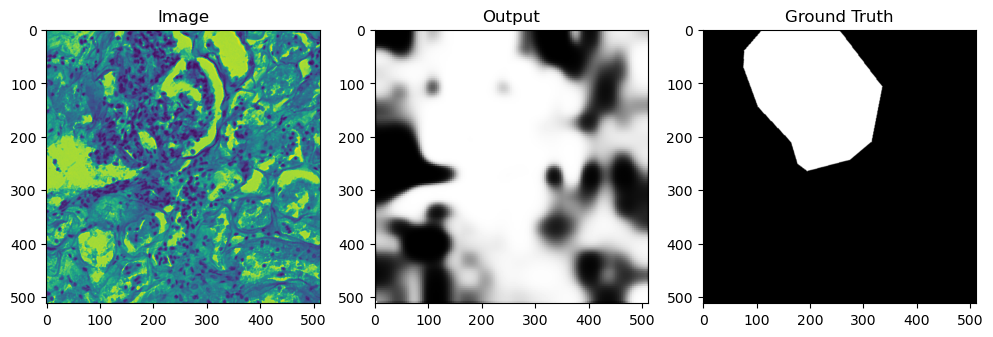

In [110]:
ID = 60
dataset = val_dataset

out = model.forward(torch.tensor([dataset[ID][0]]).type(dtype))
f, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].imshow(np.transpose(dataset[ID][0], (1, 2, 0)))
axes[1].imshow(np.transpose(out.cpu().detach().numpy()[0], (1, 2, 0)), cmap='gray')
axes[2].imshow(np.transpose(dataset[ID][1], (1, 2, 0)), cmap='gray')
axes[0].set_title('Image')
axes[1].set_title('Output')
axes[2].set_title('Ground Truth')

adjusted_mse(out, torch.tensor([dataset[ID][0]]).type(dtype), 0.15)

Text(0.5, 1.0, 'Ground Truth')

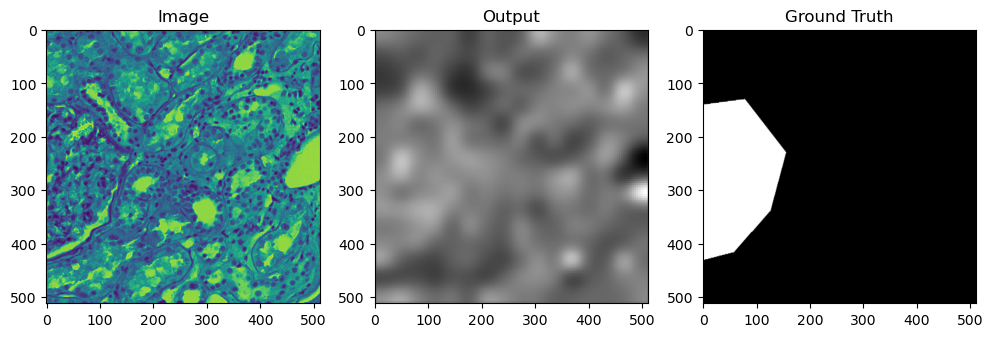

In [34]:
ID = 71
dataset = val_dataset

out = model.forward(torch.tensor([dataset[ID][0]]).type(dtype))
f, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].imshow(np.transpose(dataset[ID][0], (1, 2, 0)))
axes[1].imshow(np.transpose(out.cpu().detach().numpy()[0], (1, 2, 0)), cmap='gray')
axes[2].imshow(np.transpose(dataset[ID][1], (1, 2, 0)), cmap='gray')
axes[0].set_title('Image')
axes[1].set_title('Output')
axes[2].set_title('Ground Truth')